# Suggested Solution Workbook

**Note: This is only a suggested way of solving the problem. This solution is in no way complete and needs significant improvements, something we hope the competition participants will be able to do.**

One way of solving this problem is to convert text features into categorical features (as was suggested in the last workbook) and then naively training a classifier. However, this is not the ideal way to model the solution.  In this workbook we look at a slightly different way of approaching the problem. 

#### Step 1: We try to quantify the textual information that is given to us. 
For instance let's say the bowler for a particular delivery is Jasprit Bumrah, what we need is a set of features that can model Jasprit, we can look at things like wickets taken in that particular match, economy rate upto that point in the game, career figures, last 5 match figures etc. Using a similar approach we try to model other variables. 
  
Another question we have to look at is what factors would affect the probability of a wicket in the next ball, if we know the factors then we can try to model them as discussed above. Few that are obvious are

1. State of the game
2. Bowler
3. Batsman
4. Bowler and Batsman dynamics
5. Venue

Next we think of features that can model each of the factors above

1. State of the game: format of the game, chasing or batting first, required rate, runs scored in last 6 balls, wickets in last 6 balls, current run rate etc.

2. Bowler : Career figures like strike rate, average, last 5 match figures, economy rate in this match, wickets in this match, runs given in last 6 balls, wickets taken in last 6 balls (note: this would be different then the wickets taken in the last 6 balls feature from the state of the game)etc.

3. Batsman : runs in last 5 matches, career average, career strike rate, strike rate in last 5 matches, strike rate in this match, balls faced in this match, runs scored in last 6 balls, balls since last boundary scored etc.

4. Bowler and Batsman dynamics: This has features that represent the dynamics between current batsman and bowler a few of these could be number of times the batsman has been dismissed by this bowler, historical average against the bowler, runs scored this could also have generic features ( like if the batsman is right handed then the bowler's average against right handed batsman or batsman's average against seam bowling if the bowler is a seam bowler)

5. Venue : average number of wickets per innnigs in the last 5 matches at this venue, this could also include venue bowler dynamics like strike rate of seam bowlers at this venue etc

Once we have added the above features into our dataset we can remove the textual information without worrying about the loss of information

#### Step 2: Next we try to find the best prediction variable. What other information can we predict out of the dataset?

In our dataset we also have the information about 
1. runs scored in the next ball
2. number of runs scored in the next 6 balls
3. if there was a wicket in the next 6 balls(not just the next ball)

We can try to use this information to finally predict a wicket. However as we won't have this information available in realtime, we can't use this information directly. 
Instead we can use the training dataset to train a few feeder models for these complex features. For instance we can try to train a model on the training dataset to predict the runs in the next ball and then use that prediction as a feature(this way we can generate more complex features) to predict the probability of wicket. (Use caution with this approach as this makes the model prone to overfitting)

Below is an implementation of the few ideas given above. improvements on top of this could be:

1. In the below implementation we only model state of the game features given above, an obvious improvement could be to include other features
2. Below we train seprate models for chasing and also for different formats, however features like batsman bowler dynamics, venue can be common across formats think of ways to use those across formats.
3. Use specific feeder models for different factors(batsman, bowler etc), for example you may want to train a model on the runs scored by the current batsman in the next 6 balls using batsman features and then use that prediction as a feature for the final model.( Again this makes the model prone to overfitting)
4. In the below implementation we don't optimize the threshold for probability(infact most of the improvements listed in the previous workbook can probably be applied here as well)

Now to the actual implementation

**Step 0: Importing packages and downloading the files needed, loading the dataset into memory**

In [2]:
import pandas as pd
import numpy as np
import os.path
import math
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
    
    
## This downloads your datafile, Do not change this function
def downloadFile(downloadUrl, dataSetId, instrumentId):
      fileName = '%s.csv' % (instrumentId)
      url = downloadUrl + dataSetId + '/' + fileName

      response = urlopen(url)
      status = response.getcode()
      if status == 200:
          print('Downloading the dataset %s' % (fileName))
          with open(fileName, 'w') as f:
              f.write(response.read().decode('utf8'))
          return True
      else:
          logError('File not found. Please ensure you are working with correct data set Id')
          return False

cachedFolderName='historicalData/'
dataSetId='p1'
instrumentIds=['trainingData']
downloadUrl = 'https://qq11-data.s3.amazonaws.com/'
targetVariable = 'Out'
timeKey = 'date'
startDateStr='2010/01/01'
endDateStr='2015/12/31'
if not os.path.isfile('%s.csv' % (instrumentIds[0])):
    downloadFile(downloadUrl, dataSetId, instrumentIds[0])
df = pd.read_csv('%s.csv' % (instrumentIds[0]), index_col=0, encoding='latin-1')


**Step 1: Data exploration**

In [3]:
## Data description
print(df.shape)
print(df.columns)
print(df.dtypes)

(874860, 29)
Index(['batsman_hand', 'batsman_name', 'batsman_number', 'batting_team_name',
       'bowler_hand', 'bowler_name', 'bowler_style', 'bowling_team_name',
       'country_group', 'cumulative_balls_bowled', 'cumulative_balls_faced',
       'cumulative_balls_faced_nf', 'innings', 'innings_ball_number',
       'innings_over', 'innings_runs_before_ball', 'innings_wickets',
       'match_format', 'match_quality', 'over_ball', 'pplay_group',
       'required_run_rate', 'target', 'toss_choice', 'toss_winner',
       'venue_name', 'chasing', 'PreviousBallOut', 'Out'],
      dtype='object')
batsman_hand                  object
batsman_name                  object
batsman_number                 int64
batting_team_name             object
bowler_hand                   object
bowler_name                   object
bowler_style                  object
bowling_team_name             object
country_group                 object
cumulative_balls_bowled        int64
cumulative_balls_faced         

**Step 3: Splitting the data**
#### 3a. Separating the dataset for 20 over format and 50 over format, also for chasing and batting first

In [4]:
## extracting 20 over format games
data20 = df.copy()
data20 = data20[data20["match_format"]==20]

## splitting them by chasing or batting first
data20_chasing = data20.copy()
data20_chasing = data20_chasing[data20["chasing"]==1]
data20_first = data20[data20["chasing"]==0]

## extracting 50 over format games
data50 = df.copy()
data50 = data50[data50["match_format"]==50]

## splitting them by chasing or batting first
data50_chasing = data50.copy()
data50_chasing = data50_chasing[data50["chasing"]==1]
data50_first = data50[data50["chasing"]==0]


#### 3b. Separating the dataset into train and test set
(here I'm using a fixed index becuase I didn't want to keep data for the same match in both train and test set, you could divide in any way you want)

In [5]:
data50_chasing_train = data50_chasing.copy()[:165444]
data50_chasing_test = data50_chasing.copy()[165444:]


**Step 4: Creating new features**

We create features to capture the state of the game, bowler/batsman characterstics and features for feeder models

In [6]:
##This function adds the following features:
## State of the game features:
## a. tossWin: Did the batting team win the toss?
## b. runRateLast5: runRate in last 5 overs
## c. wicketsLast5: wickets in last 5 overs
## d. runsLast6: runs in last 6 balls

## Bowler form features
## a. bowlerRunsLast6 : runs given by bowler in last 6 balls
## b. bowlerRunRateThisMatch: bowler economy in the game so far
## c. bowlerWicketsThisMatch: wickets taken by the bowler in the game so far
## d. bowlerRunsThisMatch: runs given by the bowler in the game so far

## We also create a few predicton variables features 
## (i.e. these features include future information and 
## we will try to predict these)
## a. runsNext6: runs in next 6 balls
## b. wicketsNext6: wickets in last 6 balls
## c. runsNext: runs in the next ball

def addNewFeatures(data):

    #state of the game features
    runsLast6=np.zeros(len(data))
    tossWin = np.zeros(len(data))
    runRateLast5 = np.zeros(len(data))
    wicketsLast5 = np.zeros(len(data))
    runsNext6   = np.zeros(len(data))
    wicketsNext6 = np.zeros(len(data))
    runsNext = np.zeros(len(data))

    # bowler form features
    bowlerRunsLast6 = np.zeros(len(data))
    bowlerRunRateThisMatch = np.zeros(len(data))
    bowlerWicketsThisMatch = np.zeros(len(data))
    bowlerRunsThisMatch = np.zeros(len(data))

    ball_number_array= data['innings_ball_number']
    bowler_ball_number = data['cumulative_balls_bowled']
    bowler_name = data["bowler_name"]
    runs_array = data['innings_runs_before_ball']
    wickets = data['innings_wickets']
    toss_winner = data['toss_winner']
    batting_team_name = data['batting_team_name']
    for i in range(0,len(data)):
        if i+1 < len(data) and ball_number_array[i+1]>0:
            runsNext[i] = runs_array[i+1] - runs_array[i]
        else:
            runsNext[i] = runsNext[i-1]

        if i+6 < len(data) and ball_number_array[i+6]>5:
            runsNext6[i] = runs_array[i+6] - runs_array[i]
        else:
            runsNext6[i] = runsNext6[i-1]

        if i+6 < len(data) and ball_number_array[i+6]>5:
            wicketsNext6[i] = int((wickets[i+6] - wickets[i])>0)
        else:
            wicketsNext6[i] = wicketsNext6[i-1]

        tossWin[i] = int(toss_winner[i]==batting_team_name[i])
        if ball_number_array[i]<30:
            runRateLast5[i] = (runs_array[i]/(ball_number_array[i]+1))*6
            wicketsLast5[i] = wickets[i]
        else:
            runRateLast5[i] = (runs_array[i] - runs_array[i-30])/5
            wicketsLast5[i] = wickets[i] - wickets[i-30]

        if ball_number_array[i]<6:
            runsLast6[i] = (runs_array[i]/(ball_number_array[i]+1))*6
        else:
            runsLast6[i] = runs_array[i] - runs_array[i-6]

        bowler = bowler_name[i]

        j = 1
        while True:
            if bowler_ball_number[i] == 0:
                bowlerRunsThisMatch[i] = 0
                bowlerWicketsThisMatch[i] = 0
                break
            if bowler_name[i - j] == bowler:
                bowlerRunsThisMatch[i] = bowlerRunsThisMatch[i - j] + (runs_array[i - j + 1] - runs_array[i - j])
                bowlerWicketsThisMatch[i] = bowlerWicketsThisMatch[i - j] + (wickets[i - j + 1] - wickets[i - j])
                break
            j += 1

        if bowler_ball_number[i] == 0:
            bowlerRunRateThisMatch[i] = 4
        else:
            bowlerRunRateThisMatch[i] = (bowlerRunsThisMatch[i] / bowler_ball_number[i]) * 6


    data['runsLast6'] = runsLast6
    data['tossWin'] = tossWin
    data['runRateLast5'] = runRateLast5
    data['wicketsLast5'] = wicketsLast5
    data['runsNext6'] = runsNext6
    data['wicketsNext6'] = wicketsNext6
    data['runsNext'] = runsNext

    data['bowlerRunsLast6'] = bowlerRunsLast6
    data['bowlerRunRateThisMatch'] = bowlerRunRateThisMatch
    data['bowlerWicketsThisMatch'] = bowlerWicketsThisMatch

    # data=data.drop(columns=["toss_winner", "batting_team_name"])
    return None


### Suggested Improvement: You could model other possible features**
- bowlerAverageThisMatch
- bowlerAverageLast5Match
- bowlerStrikeRateLast5Match
- bowlerCareerAverage
- bowlerCareerStrikeRate

Possible batsman form features
- batsmanRunsLast6 
- batsmanStrikeRateThisMatch 
- batsmanRunsThisMatch 
- batsmanAverageLast5Match
- batsmanAverageLast5Match


In [7]:
addNewFeatures(data50_chasing_train)
addNewFeatures(data50_chasing_test)


**Step 5: Dropping some textual columns**

Since we've added the features quantifying textual information 
#### Note: at the moment,  we're losing some information here as we've only added feature representation for bowler and state of the game - you should create more features to fully capture the information

We also don't remove powerplay textual information because in this model we assume converting that into categorical variable is enough

In [8]:
drop_columns = ["batsman_hand", 'batsman_name', 'batsman_number', 'batting_team_name',
                "bowler_hand", "bowler_name", "bowler_style", "bowling_team_name", "country_group", "innings", "match_format", 'toss_choice',
                "toss_winner", 'match_quality', 'venue_name', 'chasing']

data50_chasing_train = data50_chasing_train.drop(columns=drop_columns)
data50_chasing_test = data50_chasing_test.drop(columns=drop_columns)


**Step 6: Converting the remaining textual features (Powerplay information) into categorical variables**

In [9]:
from sklearn import preprocessing

feature_dict ={}
for feature in data50_chasing_train.columns:
    if data50_chasing_train[feature].dtype==object:
        le = preprocessing.LabelEncoder()
        fs = data50_chasing_train[feature].unique()
        f_dict = {}
        le.fit(fs)
        data50_chasing_train[feature] = le.transform(data50_chasing_train[feature])
        data50_chasing_test[feature] = le.transform(data50_chasing_test[feature])
        feature_dict[feature] = le


**Step 7: Taking out the prediction variables from dataset**

We are predicting:
1. Out: is this ball a wicket or not?
2. runsNext6: runs in next 6 balls
3. wicketsNext6: wickets in last 6 balls
4. runsNext: runs in the next ball

In [10]:
out = data50_chasing_train['Out']
del data50_chasing_train['Out']

out_test = data50_chasing_test['Out']
del data50_chasing_test['Out']

wicketsNext6 = data50_chasing_train['wicketsNext6']
del data50_chasing_train['wicketsNext6']
del data50_chasing_test['wicketsNext6']

runsNext6 = data50_chasing_train['runsNext6']
del data50_chasing_train['runsNext6']
del data50_chasing_test['runsNext6']

runsNext = data50_chasing_train['runsNext']
del data50_chasing_train['runsNext']
del data50_chasing_test['runsNext']


**Step 8: Training Feeder models on train dataset**

Our final aim is to predict if the given ball is a wicket or not. However, there is other informmation about the game, **which if we knew,** we could use to predict a wicket, such as runs scored in the next 6 balls.

Now obviously, we won't have this information available in realtime because it only becomes avail;able as the game plays out. BUT, it might be easier to forecast, given all the information we do have, compared to predicting if a given ball is a wicket.

So, we can use the training dataset to train a few feeder models, which take in all of the available information upto that point in the game and predict these variables. 

Right now, we train three models on the training dataset to predict:
- runsNext6: runs in next 6 balls
- wicketsNext6: wickets in last 6 balls
- runsNext: runs in the next ball

We will then use the predictions of these models as a feature in our final model to predict the probability of wicket. 

This approach allows to predict a few interim features about the state of the game, which are easier to predict, and hence improve the overall performance of our model.

**Note: Use caution with this approach, if you go overboard andpredict too many features this way, this makes the model prone to overfitting)**



In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## creating feeder models 
rforest_model_runs_next6 = RandomForestRegressor(n_estimators=100, max_depth=8,random_state=0).fit(data50_chasing_train,runsNext6)
rforest_model_runs_next = RandomForestRegressor(n_estimators=100, max_depth=8,random_state=0).fit(data50_chasing_train,runsNext)
rforest_model_wickets_next6 = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=0).fit(data50_chasing_train,wicketsNext6)

## predictions from these models 
wicketsNext6 = rforest_model_wickets_next6.predict(data50_chasing_train)
runsNext = rforest_model_runs_next.predict(data50_chasing_train)
runsNext6 = rforest_model_runs_next6.predict(data50_chasing_train)
## adding predictions as features in the dataset
data50_chasing_train['wicketsNext6'] = wicketsNext6
data50_chasing_train['runsNext6'] = runsNext6
data50_chasing_train['runsNext'] = runsNext

## predictions from these models 
wicketsNext6 = rforest_model_wickets_next6.predict(data50_chasing_test)
runsNext = rforest_model_runs_next.predict(data50_chasing_test)
runsNext6 = rforest_model_runs_next6.predict(data50_chasing_test)
## adding predictions as features in the dataset
data50_chasing_test['wicketsNext6'] = wicketsNext6
data50_chasing_test['runsNext6'] = runsNext6
data50_chasing_test['runsNext'] = runsNext


**Step9: Training the wicket probability model and looking at the accuracy(Moment of truth)**

In [12]:
rforest_model_out = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=0).fit(data50_chasing_train,out)

accuracy = rforest_model_out.score(data50_chasing_test, out_test)
print(accuracy)

0.9746902955223157


In [24]:
rforest_predictions = rforest_model_out.predict(data50_chasing_test) 
y_scores = evaluate_clf.predict_proba(data50_chasing_test)[:, 1]
lg = log_loss(out_test, y_scores)
print(lg)

0.11625858179468526


**This is pretty decent improvement over our last random forest model in both accuracy and logloss, considering we actually removed a lot of textual information and didn't include the features to compensate**


**Next we try to look at feature importance and look at other metrics like AUC ROC Curve**

In [15]:
evaluate_clf = rforest_model_out
for i in range(len(data50_chasing_test.columns)):
    print(data50_chasing_test.columns[i], evaluate_clf.feature_importances_[i])


cumulative_balls_bowled 0.0455326535590099
cumulative_balls_faced 0.09711383171595628
cumulative_balls_faced_nf 0.04144952282843958
innings_ball_number 0.08809410124218794
innings_over 0.04217499061116407
innings_runs_before_ball 0.053620697756303314
innings_wickets 0.047453027108865856
over_ball 0.019583775426031895
pplay_group 0.012982177767769575
required_run_rate 0.11045129332448213
target 0.04028631864747816
PreviousBallOut 0.0032634005189738444
runsLast6 0.042338555123638766
tossWin 0.007399924148727263
runRateLast5 0.04967746280738971
wicketsLast5 0.01939396717311942
bowlerRunsLast6 0.0
bowlerRunRateThisMatch 0.05833198835770509
bowlerWicketsThisMatch 0.022565042809683918
wicketsNext6 0.02931207997397418
runsNext6 0.07860759697196161
runsNext 0.09036759212713757


**As we can see above some of the features we introduced using feeder models have pretty strong feature importance (runsNext for example)**

Now we compute precision-recall pairs for different probability thresholds

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


In [16]:
from sklearn.metrics import confusion_matrix, log_loss, make_scorer
from sklearn.metrics import roc_curve, precision_recall_curve, auc, recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
y_scores = evaluate_clf.predict_proba(data50_chasing_test)[:, 1]
p, r, thresholds = precision_recall_curve(out_test, y_scores)


import matplotlib.pyplot as plt

plt.style.use("ggplot")


def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """

    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(out_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'],
                       index=['neg', 'pos']))

    # plot the curve
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p)  # , color='b', alpha=0.2,
    #              where='post')
    plt.fill_between(r, p)  # , step='post', alpha=0.2,
    #                      color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');

    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
             markersize=15)
    return y_pred_adj


     pred_neg  pred_pos
neg     38120      2085
pos       905       139


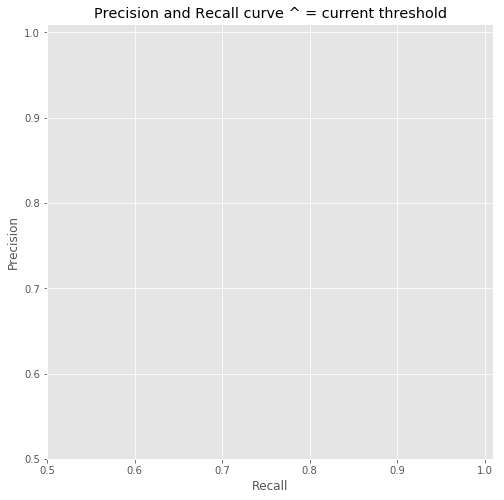

In [17]:
y_new = precision_recall_threshold(p, r, thresholds, t=0.05)

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')


def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8, 8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')



0.5963861931737775


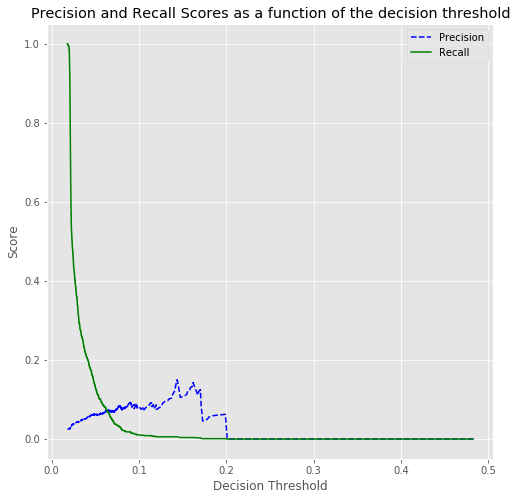

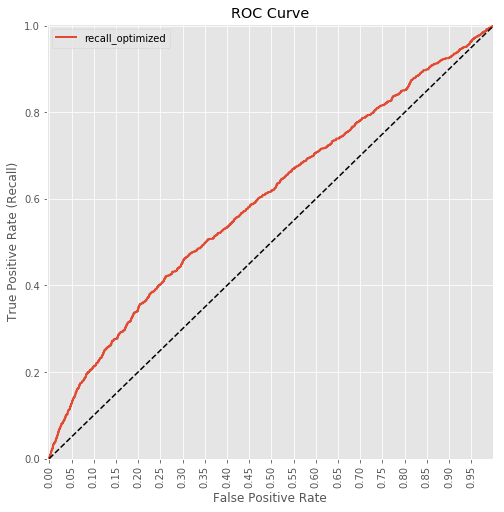

In [19]:
plot_precision_recall_vs_threshold(p, r, thresholds)

fpr, tpr, auc_thresholds = roc_curve(out_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [21]:
accuracy_score(out_test, y_new)

0.9275133942641034

**Last time we had an AUC of around 0.53 we see that just by including a few basic features it's already close to 0.6 so that's a pretty good improvement**